<a href="https://colab.research.google.com/github/akshaykoul-bit/tfx-kubeflow/blob/chestxray/chestxray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install kubeflow sdk**

In [ ]:
# KFP
!pip install --upgrade kfp

# **Import libraries**

In [ ]:
import kfp
from kfp.v2 import dsl
from kfp.v2.dsl import component
from kfp.v2.dsl import (
    Input,
    InputPath,
    Output,
    Artifact,
    Dataset,
    Model,
    Metrics
)

# **Component to download data from kaggle, augment data using ImageDataGenerator, and build and train a Conv2D model**

In [ ]:
@component(
    packages_to_install=["scipy","opendatasets","tensorflow","pillow"],
    output_component_file="build_and_train_model_component.yaml"
)
def download_data_and_train_model(url:str, output_model:Output[Model],output_history: Output[Artifact]):
  
  import tensorflow as tf
  import pickle
  import os
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  import opendatasets as od
  import json
  import tensorflow.keras as keras
  from PIL import ImageFile,Image
  ImageFile.LOAD_TRUNCATED_IMAGES = True

  dictionary = {"username":"xxxxxx","key":"xxxxxxxxxxxxxxxxxxxxxxxxxxxx"}
      
  with open("kaggle.json", "w") as outfile:
    json.dump(dictionary, outfile)
  
  od.download(url)
  
  data_path = "chest-xray-pneumonia/chest_xray/chest_xray"
  train_dir = os.path.join(data_path,'train')
  test_dir = os.path.join(data_path,'test')
  val_dir = os.path.join(data_path,'val')

  labels = []
  numtrain = []
  numtest = []
  numval = []
  splitls = ['train','test','val']
  for i,pths in enumerate([train_dir,test_dir,val_dir]):
      for lbl in os.listdir(pths):
        if lbl in ['NORMAL','PNEUMONIA']:
            labels.append(lbl)
            if splitls[i]=='train':
                print('train')
                print(lbl,':',len(os.listdir(pths+'/'+lbl)))
                numtrain.append(len(os.listdir(pths+'/'+lbl)))
            elif splitls[i]=='test':
                print('test')
                print(lbl,':',len(os.listdir(pths+'/'+lbl)))
                numtest.append(len(os.listdir(pths+'/'+lbl)))  
            else:
                print('val')
                print(lbl,':',len(os.listdir(pths+'/'+lbl)))
                numval.append(len(os.listdir(pths+'/'+lbl))) 

  weight_for_norml = (1 / numtrain[0])*(sum(numtrain))/2.0 
  weight_for_pneum = (1 / numtrain[1])*(sum(numtrain))/2.0

  class_weight = {0: weight_for_norml, 1: weight_for_pneum}

  seed = 121

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      # validation_split=0.1
  )

  val_datagen = ImageDataGenerator(
      rescale=1./255,
  )

  target_size = (150,150)

  train_gen = train_datagen.flow_from_directory(
      train_dir,
      batch_size = 20,
      class_mode = 'binary',
      target_size = target_size,
      shuffle=True,
      seed = seed,
  )


  val_gen = val_datagen.flow_from_directory(
      val_dir,
      batch_size = 20,
      class_mode = 'binary',
      target_size = target_size,
      seed = seed,
  )

  def create_model(input_shape):
      inputs = tf.keras.Input(shape=input_shape)
      x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inputs)
      x = tf.keras.layers.MaxPooling2D(2,2)(x)
      x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inputs)
      x = tf.keras.layers.MaxPooling2D(2,2)(x)
      x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
      x = tf.keras.layers.MaxPooling2D(2,2)(x)    
      x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
      x = tf.keras.layers.MaxPooling2D(2,2)(x)
      x = tf.keras.layers.Flatten()(x)
      x = tf.keras.layers.Dense(128, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.3)(x)
      outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      model = tf.keras.Model(inputs=inputs, outputs=outputs)
      print(model.summary())
      return model

  model = create_model((150,150,3))
  print('model created')

  callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min', patience=3,restore_best_weights=True)
  print('callbacks created')

  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  print('model compiled')

  history = model.fit(train_gen,validation_data=val_gen,epochs=25,callbacks=[callbacks],class_weight=class_weight)
  print('model fitted')

  model.save(output_model.path)
  print('model saved')
  print(history.history.values())

  with open(output_history.path, "wb") as file:
    pickle.dump(history, file)

# **Component to print evaluation metrics**

In [ ]:
@component(
    packages_to_install=["tensorflow", "pandas"],
    output_component_file="eval_model_component.yaml"
)
def eval_model(input_model: Input[Model], input_history: Input[Artifact], MLPipeline_Metrics: Output[Metrics]):
    import tensorflow as tf
    import pickle

    model = tf.keras.models.load_model(input_model.path)
    with open(input_history.path, "rb") as file:
      history = pickle.load(file)
  
    vals = list(history.history.values())
    print(vals)
    MLPipeline_Metrics.log_metric("Train Loss", vals[0][-1])
    MLPipeline_Metrics.log_metric("Val Loss",  vals[2][-1])
    MLPipeline_Metrics.log_metric("Train Accuracy",  vals[1][-1])
    MLPipeline_Metrics.log_metric("Val Accuracy",  vals[3][-1])

# **Define pipeline**

In [ ]:
@dsl.pipeline(
    name="my-pipeline",
)
def my_pipeline(url: str):
    download_data_and_train_model_task = download_data_and_train_model(url=url)
    eval_model_task = eval_model(input_model=download_data_and_train_model_task.outputs['output_model'],
                                                   input_history=download_data_and_train_model_task.outputs['output_history'])

# **Compile pipeline and create a .yaml file which will be uploaded kubeflow UI**

In [ ]:
kfp.compiler.Compiler(mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE).compile(
    pipeline_func=my_pipeline,
    package_path='pipeline.yaml')

/usr/local/lib/python3.7/dist-packages/kfp/compiler/compiler.py:79: UserWarning: V2_COMPATIBLE execution mode is at Beta quality. Some pipeline features may not work as expected.
  warnings.warn('V2_COMPATIBLE execution mode is at Beta quality.'


# **Snapshot of kubeflow run**

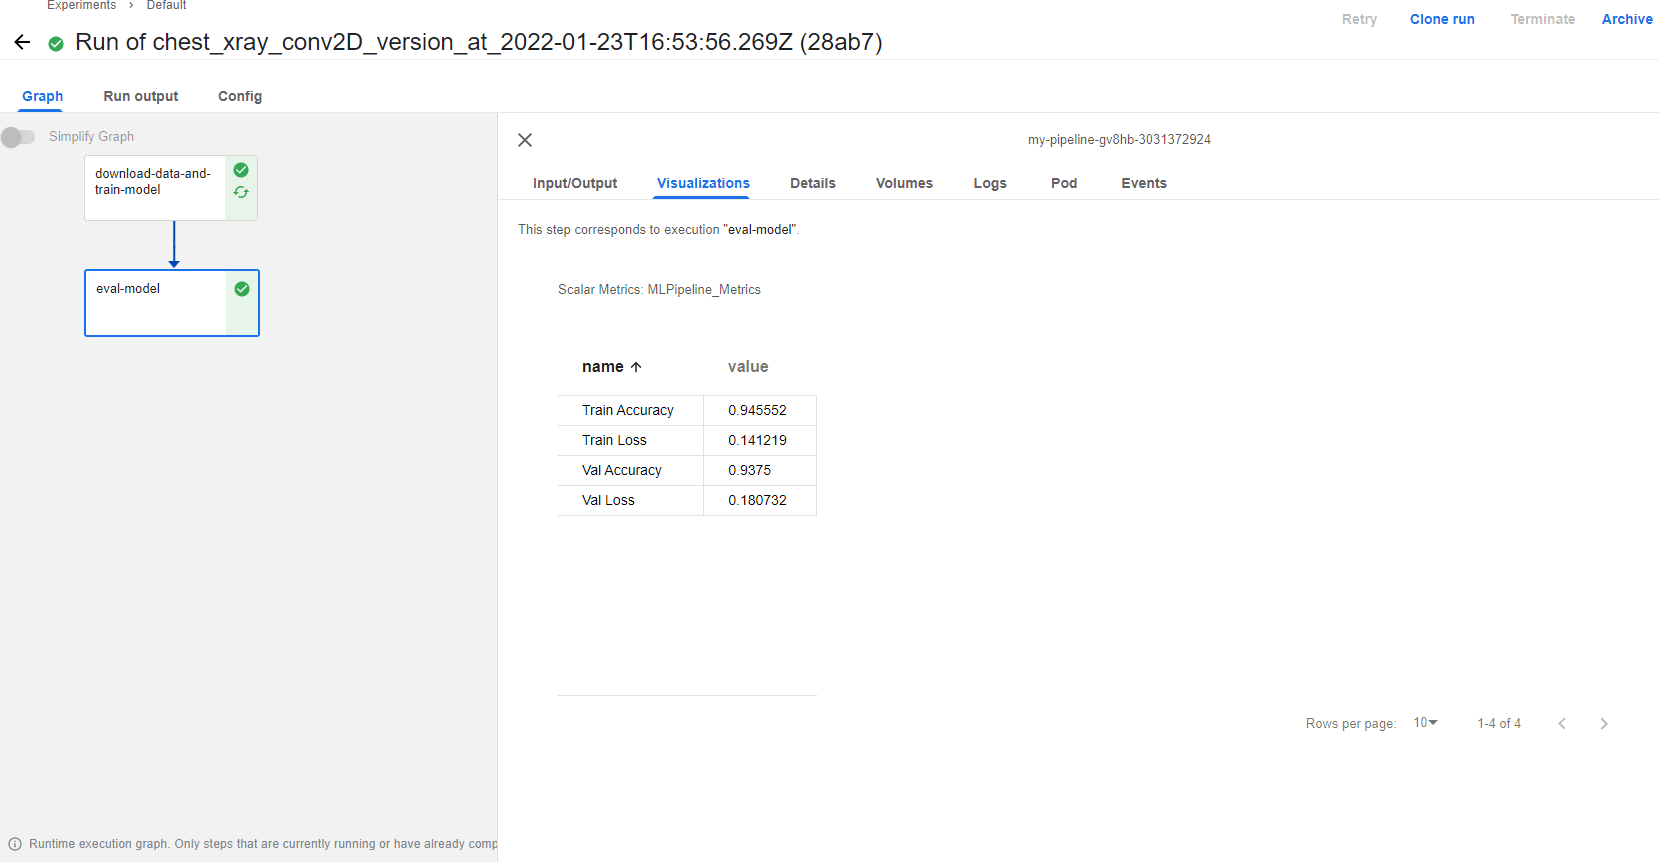